In [1]:
# Scratch notebook to set up the flow of training a basic paper-described VAE on minecraft images

import torch
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import CIFAR10

from tqdm.autonotebook import tqdm, trange

from utils.models import *
from utils.model_tools import train, test


/tmp/ipykernel_20512/1497160852.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


Using cuda device


In [3]:
torch.manual_seed(321)

model_file = 'model_files/test_cifar10_vae.pt'

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = CIFAR10(root='./data', train=False, download=True, transform=transform)
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
z_dim = 10
model = BasicAE()
model.to(device)
print(len(train_loader))

num_epochs = 30 # in the actual example this will be 200
steps_per_epoch = len(train_loader) #?

learning_rate = 0.1
weight_decay = 5 * 10**-6

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay, nesterov=True)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, learning_rate, epochs=num_epochs, steps_per_epoch=steps_per_epoch)


1563


In [5]:
train_losses_file = 'logs/vae-cifar10-ep100-train.txt'
test_losses_file = 'logs/vae-cifar10-ep100-test.txt'

train_losses = []
test_losses = []
t = trange(num_epochs)

for epoch in t:
    print(f"Epoch {epoch+1}\n-------------------------------")
    train_loss = train(train_loader, model, loss_fn, optimizer, device)
    test_loss = test(test_loader, model, loss_fn, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    #t.set_description(f"Epoch {epoch} train loss: {epoch_loss_train[-1]:.3f}")
    lr_scheduler.step()
    
torch.save(model.state_dict(), model_file)

with open(train_losses_file, 'w') as fp:
    for s in train_losses:
        fp.write("%s\n" % s)
        
with open(test_losses_file, 'w') as fp:
    for x in test_losses:
        fp.write("%s\n" % x)

print("Done!")


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1
-------------------------------
loss: 0.536044  [    0/50000]
loss: 0.200680  [32000/50000]
Test Error: 
 Avg loss: 0.187348 

Epoch 2
-------------------------------
loss: 0.199182  [    0/50000]
loss: 0.152352  [32000/50000]
Test Error: 
 Avg loss: 0.177917 

Epoch 3
-------------------------------
loss: 0.211132  [    0/50000]
loss: 0.176042  [32000/50000]
Test Error: 
 Avg loss: 0.172639 

Epoch 4
-------------------------------
loss: 0.164540  [    0/50000]
loss: 0.196191  [32000/50000]
Test Error: 
 Avg loss: 0.169684 

Epoch 5
-------------------------------
loss: 0.158623  [    0/50000]
loss: 0.170256  [32000/50000]
Test Error: 
 Avg loss: 0.167531 

Epoch 6
-------------------------------
loss: 0.146362  [    0/50000]
loss: 0.192023  [32000/50000]
Test Error: 
 Avg loss: 0.165168 

Epoch 7
-------------------------------
loss: 0.210001  [    0/50000]
loss: 0.182151  [32000/50000]
Test Error: 
 Avg loss: 0.163403 

Epoch 8
-------------------------------
loss: 0.174297 

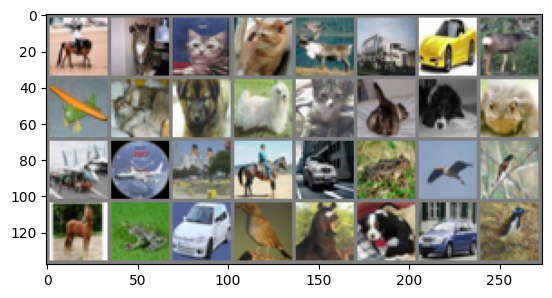

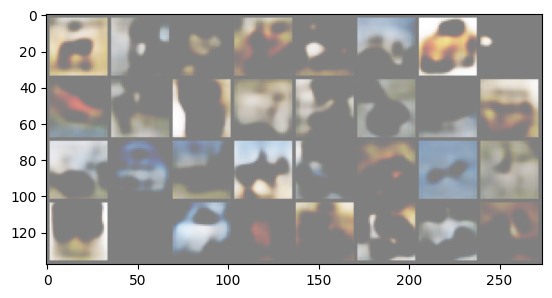

In [7]:
# Sampling model
import torchvision

model_loaded = BasicAE()
model_loaded.load_state_dict(torch.load(model_file))
model_loaded.eval()

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

sample_loader = DataLoader(test_data, batch_size=4, shuffle=True, num_workers=2)

dataiter = iter(test_loader)
images, labels = next(dataiter)

gens = model_loaded(images)
imshow(torchvision.utils.make_grid(images))
imshow(torchvision.utils.make_grid(gens))